# Analysis of Global Production Crops Over Time
## Introduction
### Background and Context
Agricultural production is the foundation of the global economy. Globally it provides jobs to over 1 billion people (Map of the month 2020) and provides food security to billions. Without agriculture, there would be no way to support our current population numbers and density. Without affordable and efficient access to food, economies would collapse. The importance of agricultural production cannot be overstated. 
As population continues to grow, so must food production. As we enter an era of increased variance in global temperatures, weather patterns, and natural disasters understanding the nature of food production trends will be necessary in assessing the health of our agricultural industries. Forecasting can help to inform law/policy makers, it can help to optimize resource allocation, and inform supply chains.
Time series analysis is a statistical and machine learning technique used to model trends and forecast future values of temporal data. This type of analysis will be effective in understanding, describing, and predicting trends in agricultural data production. Time series analysis techniques such as Autoregressive Integrated Moving Average (ARIMA), Seasonal ARIMA (SARIMA), Long Short-Term Memory (LSTM) networks, and Facebook Prophet, can be employed to model and predict crop production trends. Each of these methods offers unique advantages and limitations, depending on the underlying data structure, model complexity, and forecasting requirements.
### Objectives of the Study
This study aims to apply different time series analysis techniques to the FAOSTAT production indices dataset, obtained from the Food and Agriculture Organization of the United Nations (FAO), to forecast crop production trends. The results will provide insights into the most appropriate time series forecasting method for predicting crop production trends and offer valuable input for decision-making in agricultural planning and management.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.stattools import adfuller
from numpy import mean
sns.set_theme(style="darkgrid")
import math


## Project Dataset
### FAOSTAT Crops and Livestock Products Dataset
The Food and Agriculture Organization (FAO) is a United Nations agency dedicated to leading international efforts to combat hunger. FAO's mission is to ensure food security for all, enabling individuals to have consistent access to sufficient, high-quality food to maintain active and healthy lives.
The FAOSTAT data portal offers a diverse range of data on subjects such as food production, food security, trade, climate change, and other relevant indicators. In this study, we will concentrate on the "Crops and Livestock Products" dataset, which encompasses variables like country, year, and specific crop production data.
### Data Collection Process
The FAOSTAT portal provides a user-friendly interface for data extraction, allowing both bulk data downloads and pre-filtered selections based on specific parameters. For this study, we will utilize the pre-filtering option to obtain data specific to our target crop, location, and time series for modeling purposes. The extracted data will be saved in CSV format, facilitating further manipulation and modeling using Python3.


In [4]:
# parent directory
parent = os.path.dirname(os.getcwd())

# load main csv
wine = pd.read_csv("faostat_wine.csv")
temp = pd.read_csv("FAOSTAT_temp_change.csv")
#rain = pd.read_csv("")

### Data Pre-processing
Before starting our analysis, we cleaned up the CSV data from the FAOSTAT portal with the following steps:
- Reviewed the columns in the data table to check for irrelevant columns.
- Used python to check for the unique values for units in the dataset, and confirmed that the wine production data is all reported in tonnes, with no other units appearing.
- Converted the Year text values into Datetime format.
- Removed any extraneous records from the table by discarding any rows with null data in the Value column.
- Dropped unnecessary columns so only the Area, Year, and Value columns remain.
- Indexed the Year column in the data tables.
With these steps complete, we obtain cleaned data tables with annual wine production and temperature variation for our selected countries (Italy, Fance, Spain, and the USA).

In [5]:
#wine.head()
temp.head()
#wine.columns

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1961,1961,°C,0.837,E,Estimated value
1,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1962,1962,°C,-0.296,E,Estimated value
2,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1963,1963,°C,-0.948,E,Estimated value
3,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1964,1964,°C,0.030,E,Estimated value
4,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1965,1965,°C,-0.622,E,Estimated value


In [6]:
# Confirm only one unit in dataset
set(wine["Unit"].unique())

{'tonnes'}

In [7]:
# Set datatype of Year column to datetime
wine["Year Code"] = pd.to_datetime(wine["Year Code"],format="%Y")
temp["Year Code"] = pd.to_datetime(temp["Year Code"],format="%Y")

# Remove rows with null values in "value" column
wine = wine[wine["Value"].notna()]
temp = temp[temp["Value"].notna()]

# Remove unnecessary columns
wine = wine[["Area","Year Code","Value"]]
temp = temp[["Area","Year Code","Value"]]

# Datetime index dataframes
wine = wine.set_index("Year Code")
temp = temp.set_index("Year Code")

In [8]:
wine.head(10)

,Area,Value
Year Code,,
1961-01-01,France,4855300.0
1962-01-01,France,7497000.0
1963-01-01,France,5752370.0
1964-01-01,France,6243200.0
1965-01-01,France,6841720.0
1966-01-01,France,6225340.0
1967-01-01,France,6202620.0
1968-01-01,France,6646030.0
1969-01-01,France,5128960.0


In [9]:
print("ok")

ok


In [10]:
temp.head(10)

,Area,Value
Year Code,,
1961-01-01,France,0.837
1962-01-01,France,-0.296
1963-01-01,France,-0.948
1964-01-01,France,0.030
1965-01-01,France,-0.622
1966-01-01,France,0.421
1967-01-01,France,0.492
1968-01-01,France,-0.079
1969-01-01,France,0.017


## Assumption Testing for Time Series Analysis
### Stationarity 

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

C:\Users\jorda\AppData\Local\Temp\ipykernel_32752\636594385.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Area'], dtype='object')
  mean = df_country.rolling(window = 5).mean()
C:\Users\jorda\AppData\Local\Temp\ipykernel_32752\636594385.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Area'], dtype='object')
  std = df_country.rolling(window = 5).std()


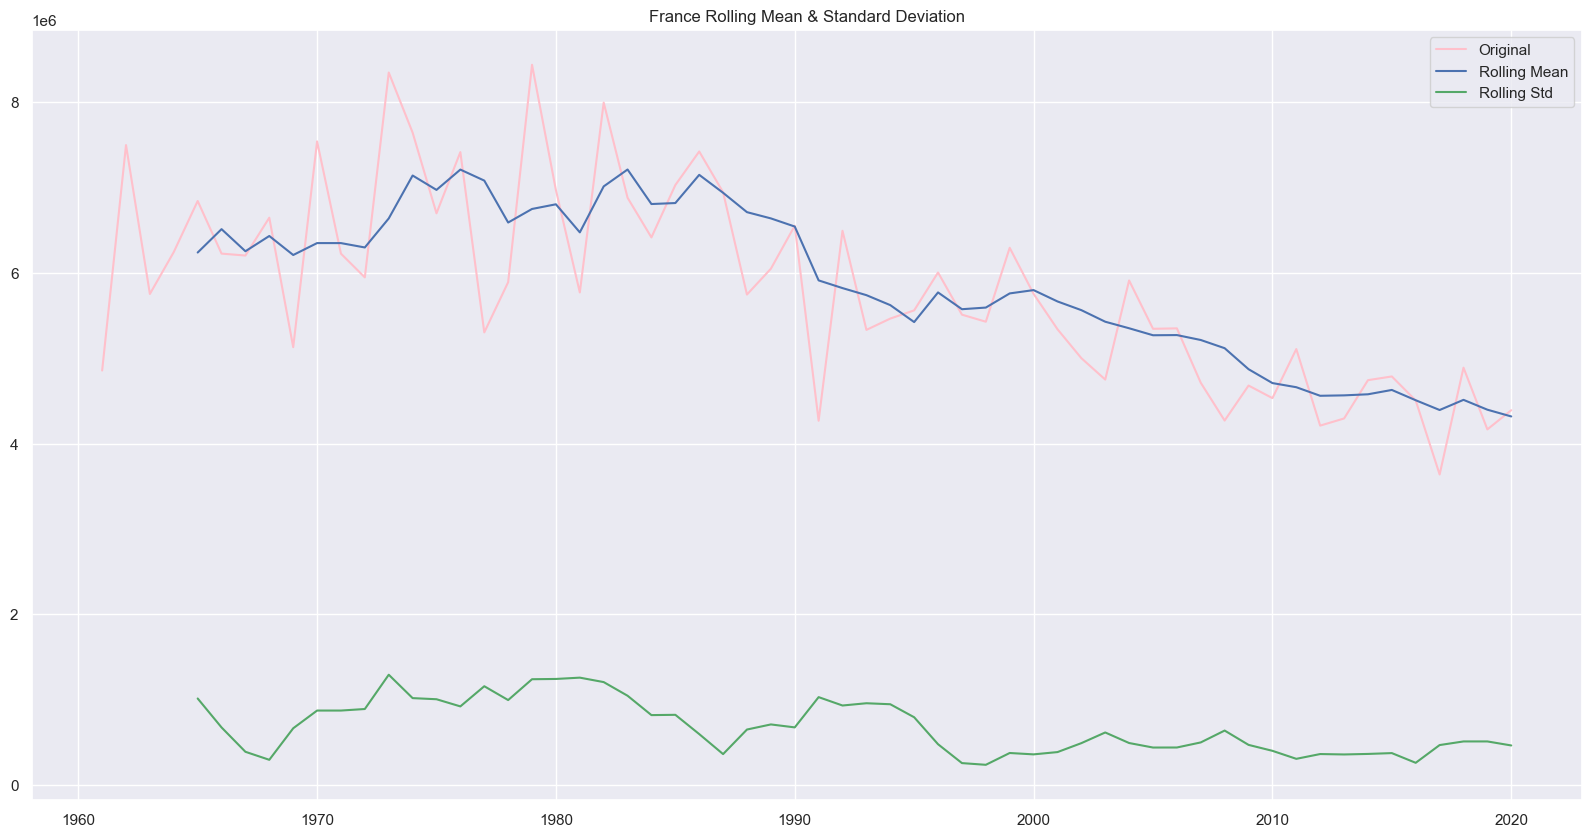

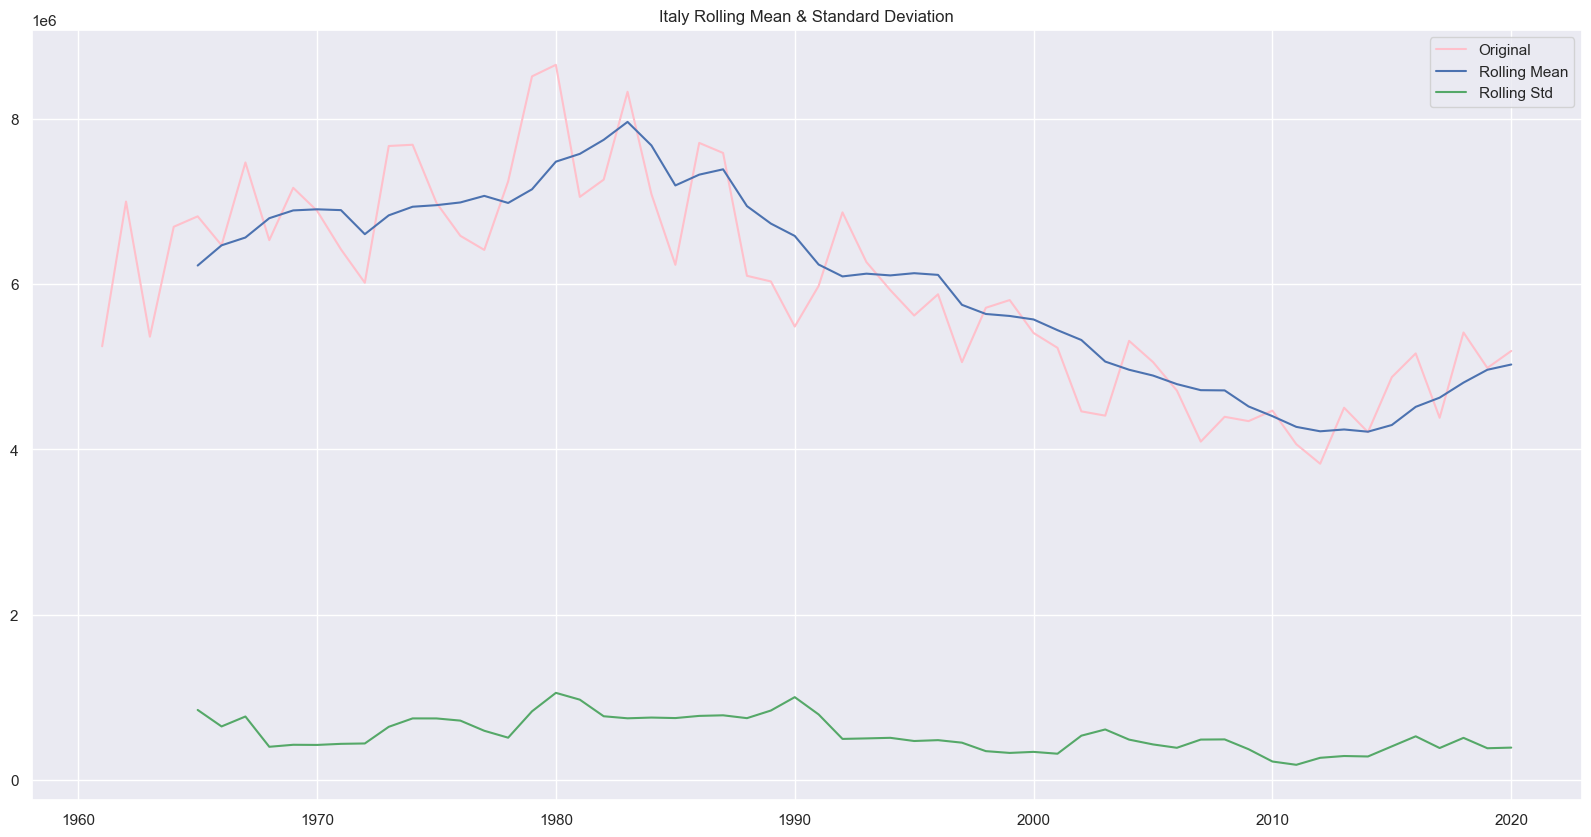

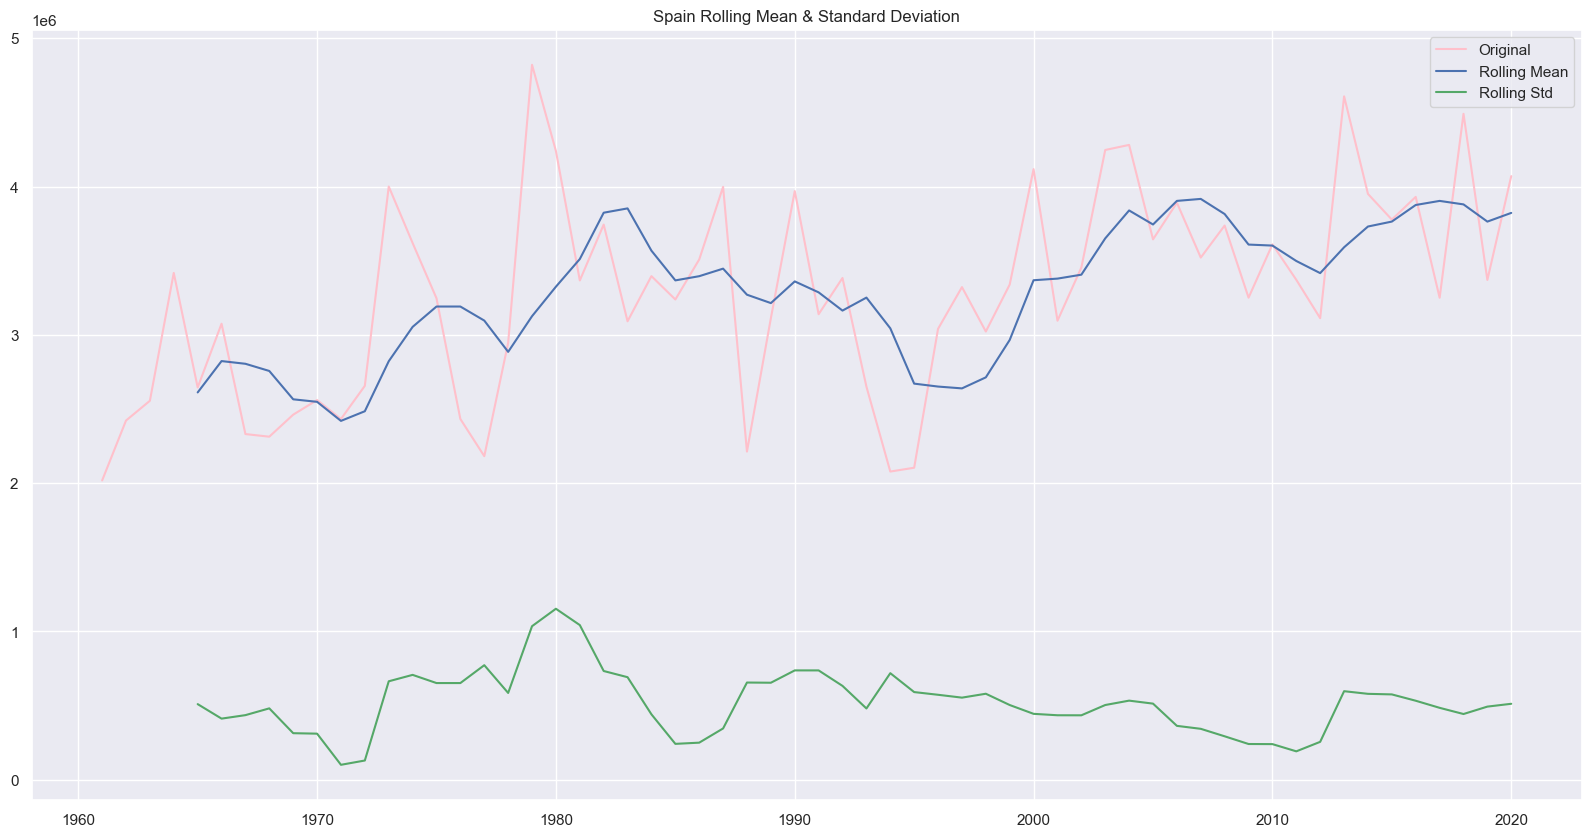

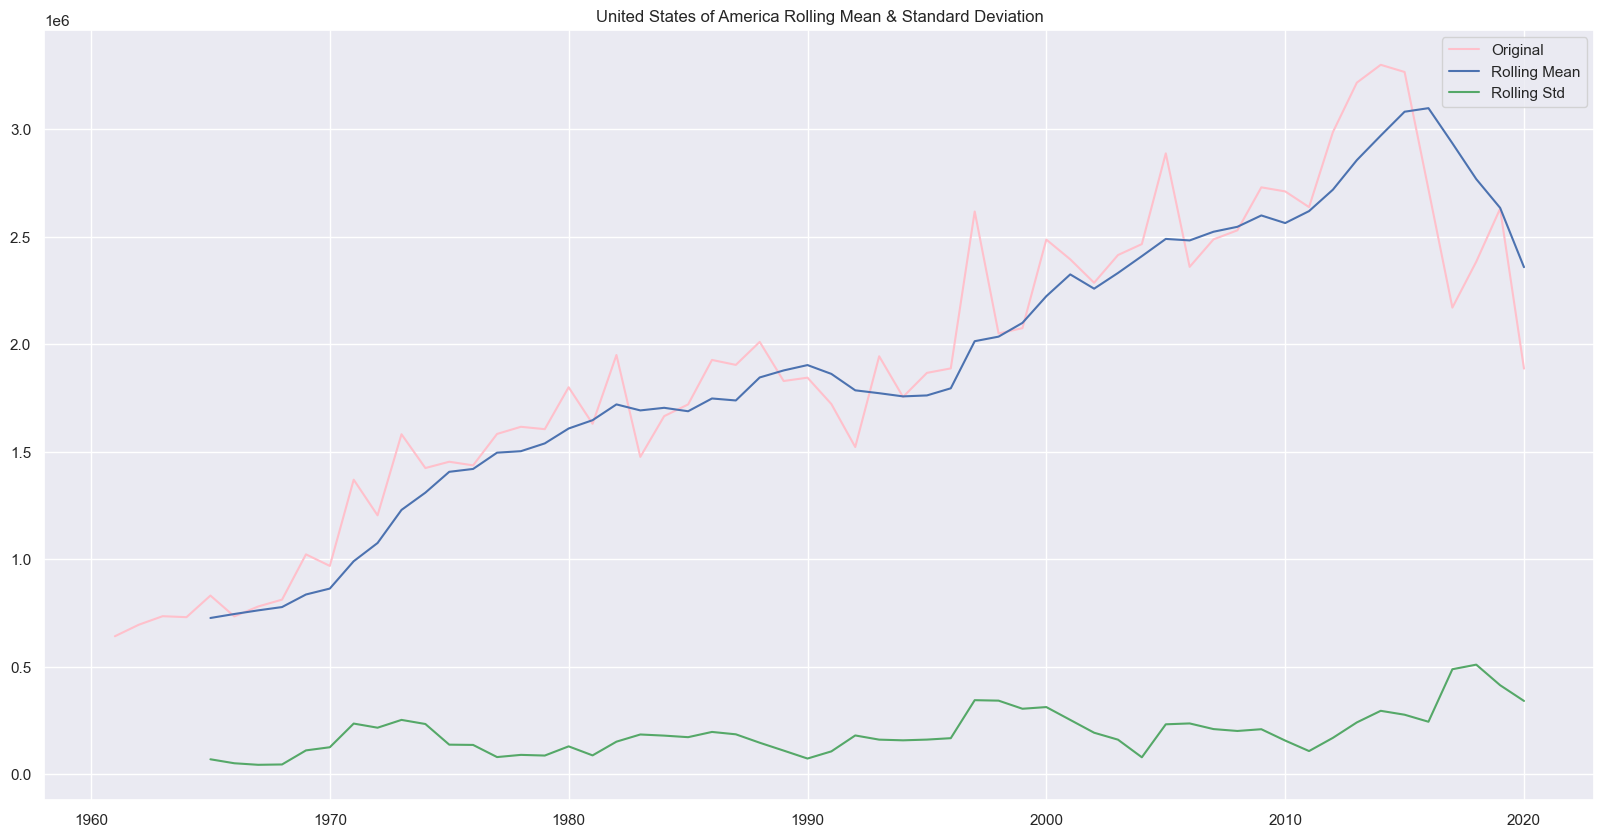

In [11]:
for country in list(wine['Area'].unique()):
    df_country = wine.loc[wine['Area'] == country].copy()
    mean = df_country.rolling(window = 5).mean()
    std = df_country.rolling(window = 5).std()

    plt.figure(figsize=(20,10))
    orig = plt.plot(df_country["Value"], color='pink',label='Original')
    mean = plt.plot(mean, color='b', label='Rolling Mean')
    std = plt.plot(std, color='g', label = 'Rolling Std')
    plt.title(country + ' Rolling Mean & Standard Deviation')
    plt.legend(loc='best')
    plt.show()

In [12]:
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value'].values)
    print(f"{country} P-value: ", result[1])    

France P-value:  0.7953154797917146
Italy P-value:  0.39445511830085606
Spain P-value:  7.061830870711466e-05
United States of America P-value:  0.3649051796358107


In [13]:
# Transformations
wine['Value_log'] = np.log(abs(wine.Value))
# Re-check Assumptions
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value_log'].values)
    print(f"{country} P-value: ", result[1])

France P-value:  0.815544950873508
Italy P-value:  0.33842127200065913
Spain P-value:  0.00013479339879580977
United States of America P-value:  0.10334505474703881


Doing log transformation on the data did not fix the problem of non-stationarity, so we will try differencing on the data

In [14]:
# Transformations: Differencing
wine['Value Transform'] = 0

for country in list(wine['Area'].unique()):
    diff = np.diff(wine[wine['Area'] == country]['Value'])
    wine.loc[wine['Area'] == country, 'Value Transform'] = np.append([0], diff)

for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value Transform'].values)
    print(f"{country} P-value: {result[1]}")

France P-value: 3.364124615587064e-24
Italy P-value: 2.2284029970221194e-15
Spain P-value: 1.2463121912921632e-06
United States of America P-value: 9.443954124681311e-18


## Exploratory Data Analysis

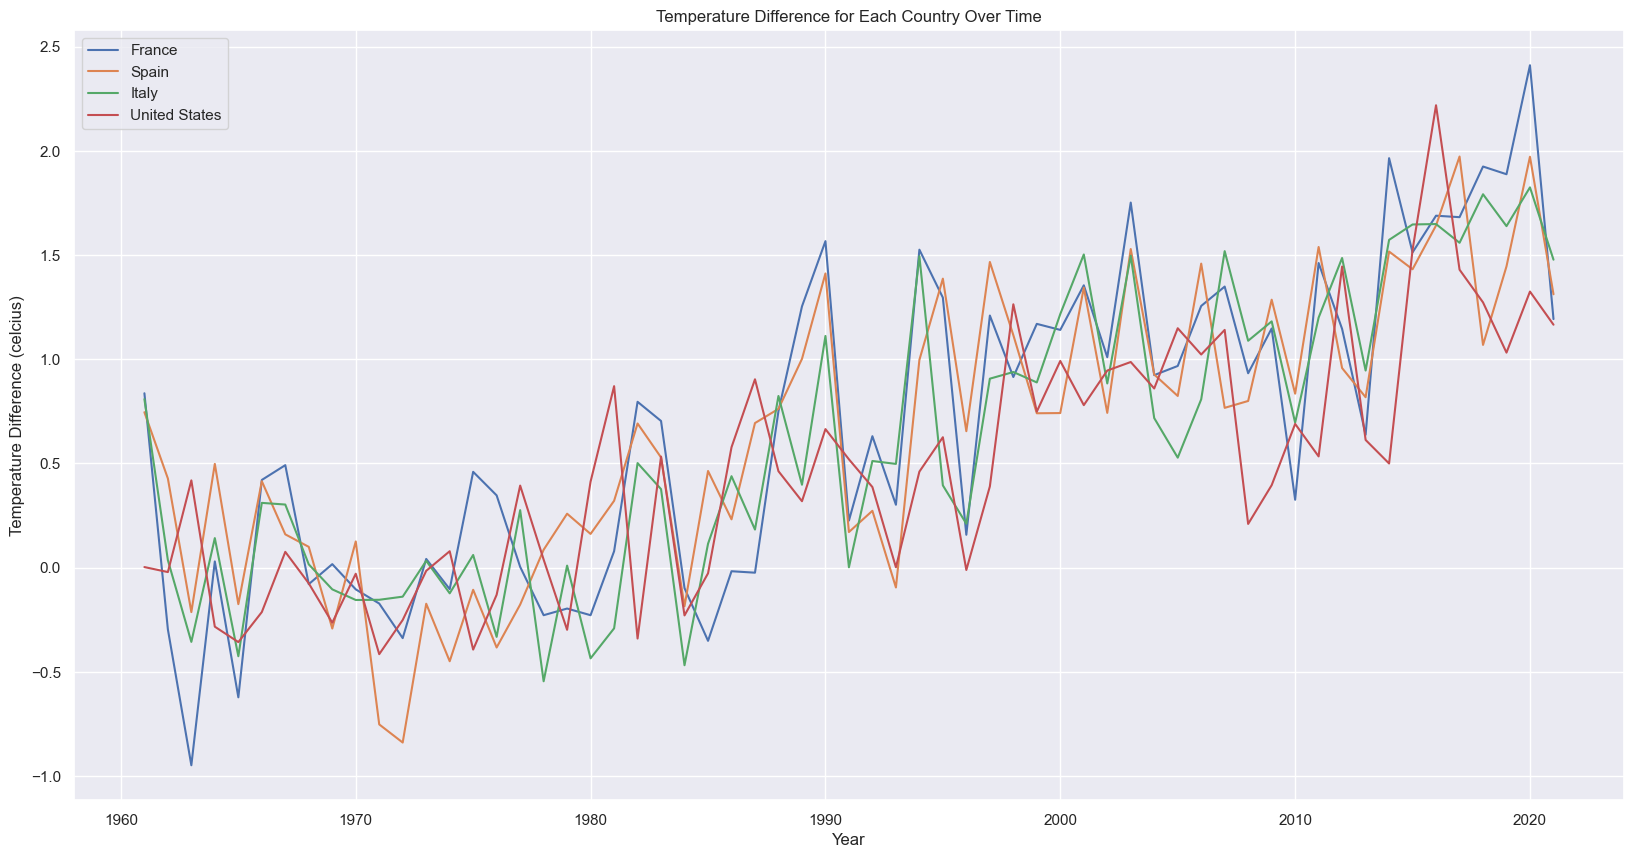

In [15]:
# Temperature
temp2 = temp.reset_index()
plt.figure(figsize=(20,10))
plt.plot(temp2[temp2['Area'] == "France"]['Year Code'], temp2[temp2['Area'] == "France"]['Value'], label = "France")
plt.plot(temp2[temp2['Area'] == "Spain"]['Year Code'], temp2[temp2['Area'] == "Spain"]['Value'], label = "Spain")
plt.plot(temp2[temp2['Area'] == "Italy"]['Year Code'], temp2[temp2['Area'] == "Italy"]['Value'], label = "Italy")
plt.plot(temp2[temp2['Area'] == "United States of America"]['Year Code'], temp2[temp2['Area'] == "United States of America"]['Value'], label = "United States")
plt.legend(loc = 'best')
plt.xlabel("Year")
plt.ylabel("Temperature Difference (celcius)")
plt.title("Temperature Difference for Each Country Over Time")
plt.show()

# Precipitation 



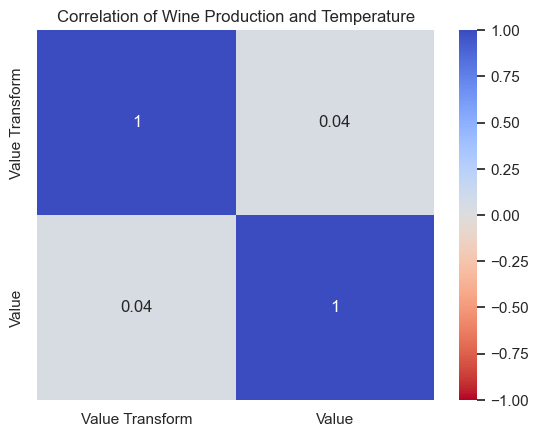

In [16]:
# Correlation Heatmap of Variables
wine2 = wine.reset_index()
corrmat = pd.DataFrame([wine2["Value Transform"], temp2["Value"]]).T.corr()
sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
plt.title("Correlation of Wine Production and Temperature")
plt.show()

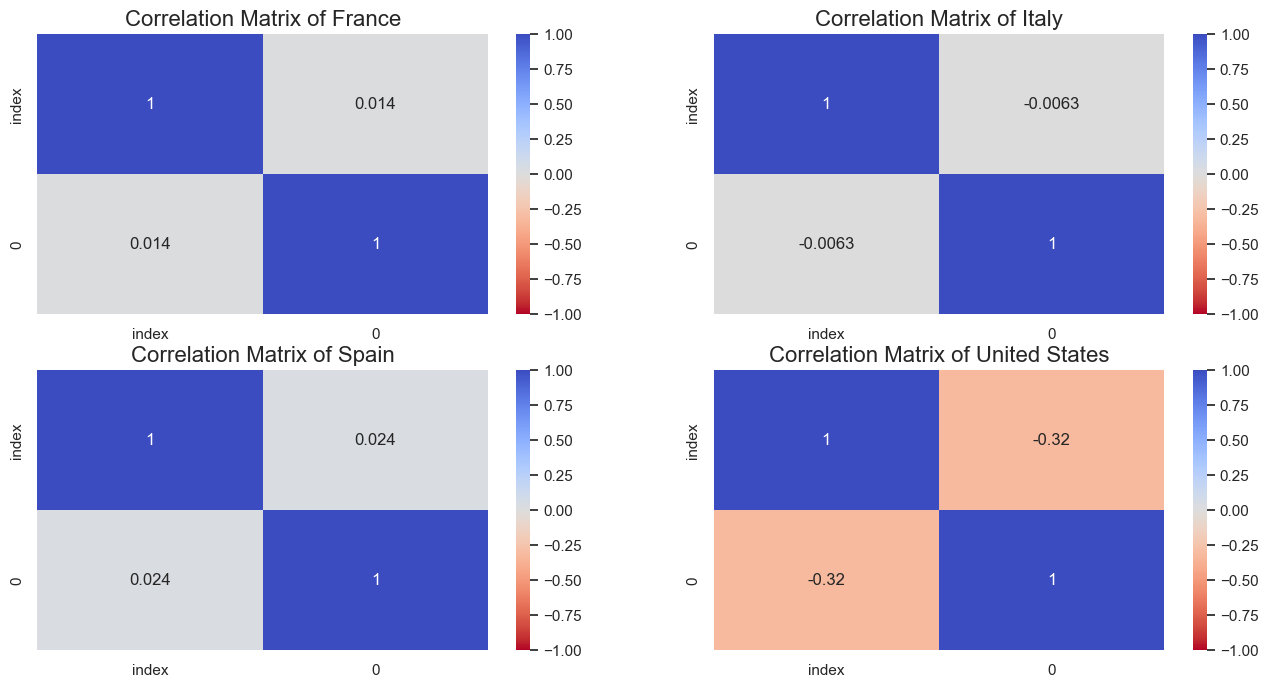

In [17]:
# Correlation Matrix for Each Country
temp2 = temp2.drop(temp2[temp2["Year Code"] == "2021-01-01"].index)
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))


corrmat2 = pd.DataFrame(np.array(wine2[wine2['Area'] == "France"]['Value Transform']), np.array(temp2[temp2['Area'] == "France"]['Value'])).reset_index().corr()

sns.heatmap(corrmat2, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0,0])
ax[0,0].set_title('Correlation Matrix of France', fontsize=16)

corrmat3 = pd.DataFrame(np.array(wine2[wine2['Area'] == "Italy"]['Value Transform']), np.array(temp2[temp2['Area'] == "Italy"]['Value'])).reset_index().corr()
sns.heatmap(corrmat3, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0,1])
ax[0,1].set_title('Correlation Matrix of Italy', fontsize=16)

corrmat4 = pd.DataFrame(np.array(wine2[wine2['Area'] == "Spain"]['Value Transform']), np.array(temp2[temp2['Area'] == "Spain"]['Value'])).reset_index().corr()
sns.heatmap(corrmat4, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1,0])
ax[1,0].set_title('Correlation Matrix of Spain', fontsize=16)

corrmat5 = pd.DataFrame(np.array(wine2[wine2['Area'] == "United States of America"]['Value Transform']), np.array(temp2[temp2['Area'] == "United States of America"]['Value'])).reset_index().corr()
sns.heatmap(corrmat5, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1,1])
ax[1,1].set_title('Correlation Matrix of United States', fontsize=16)
plt.show()

### Time Series Decomposition

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### France

In [19]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 4
decomposition = seasonal_decompose(wine[wine["Area"]=='France'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

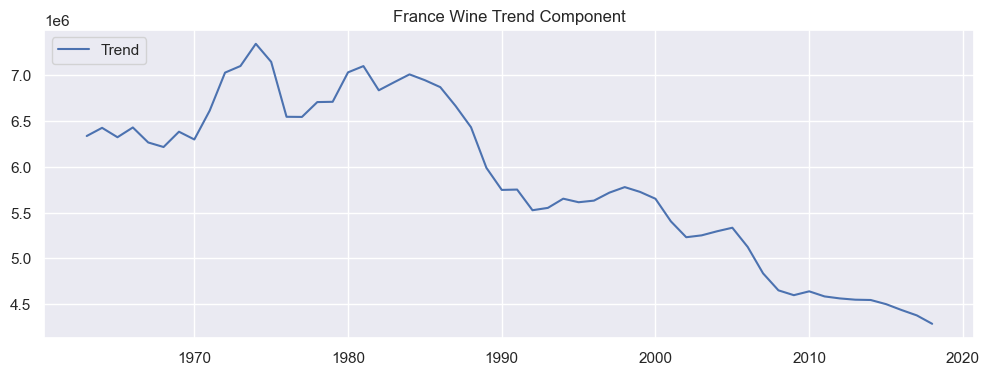

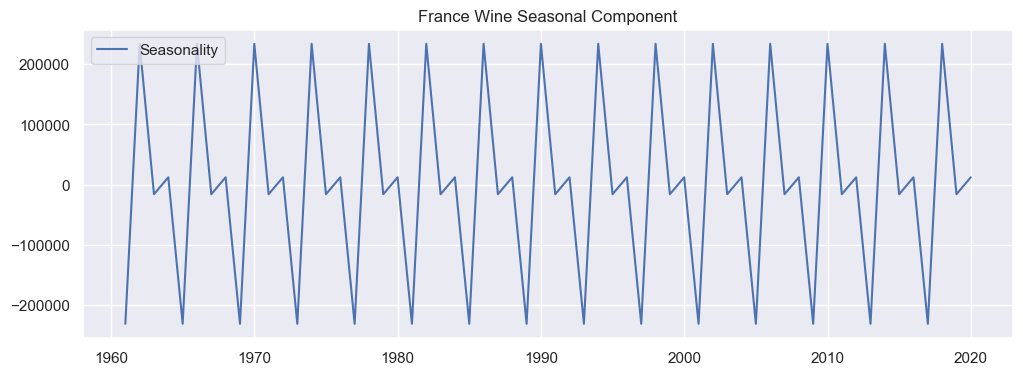

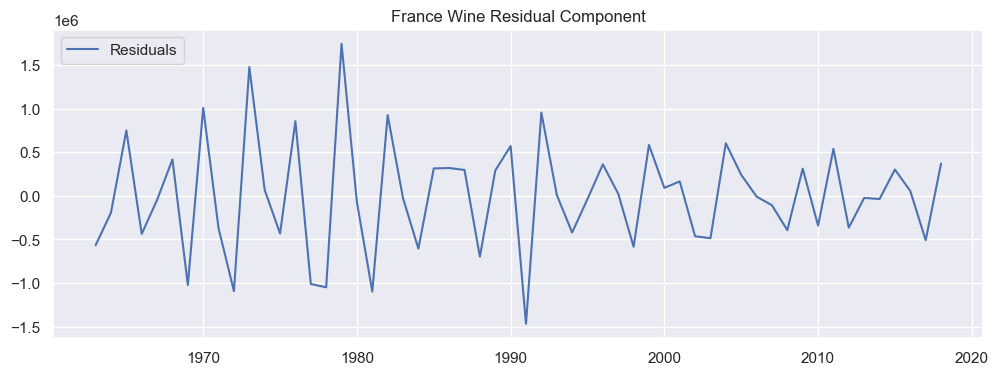

In [20]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("France Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("France Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("France Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

#### Italy

In [21]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 5
decomposition = seasonal_decompose(wine[wine["Area"]=='Italy'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

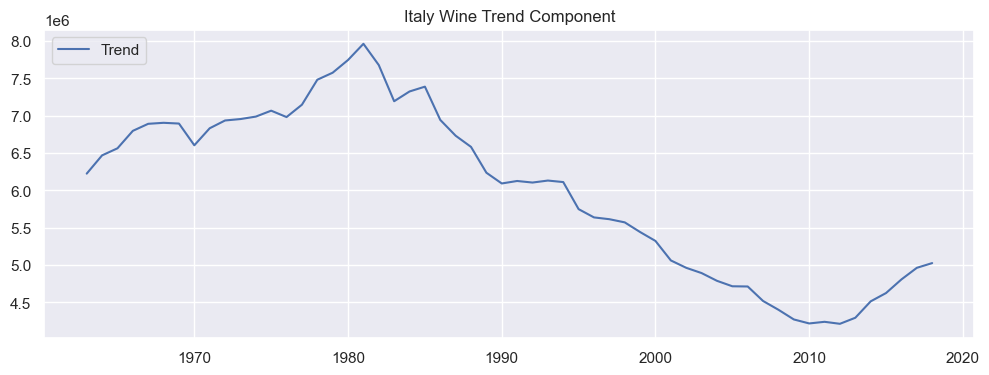

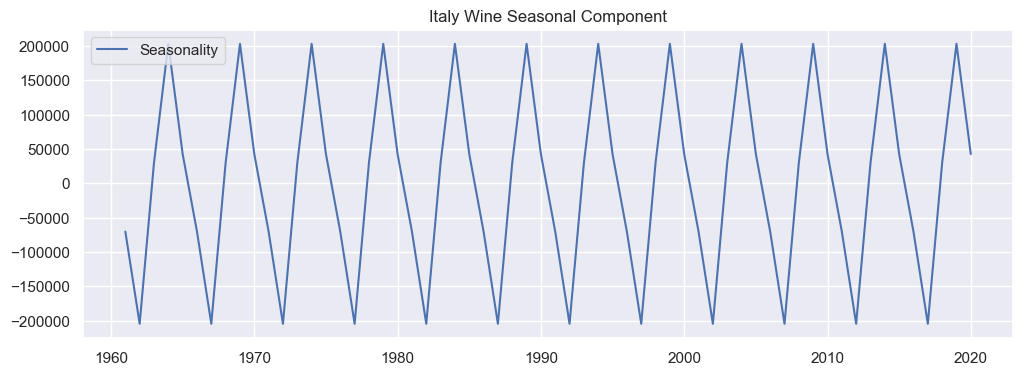

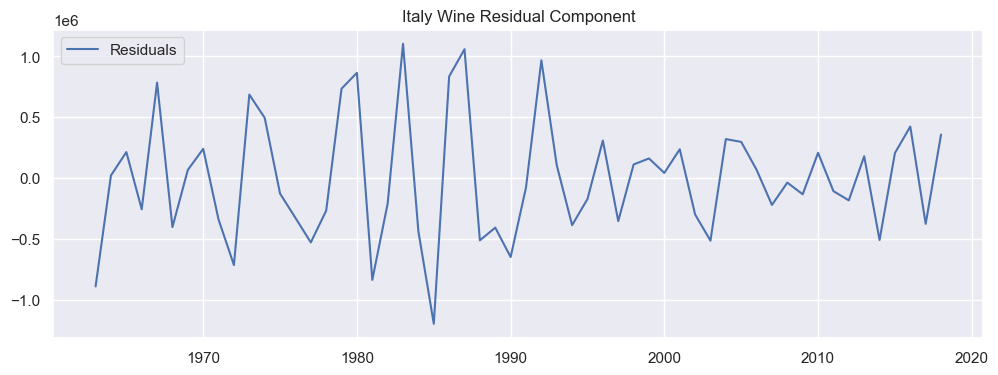

In [22]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("Italy Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("Italy Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("Italy Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

#### Spain

In [23]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 6
decomposition = seasonal_decompose(wine[wine["Area"]=='Spain'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


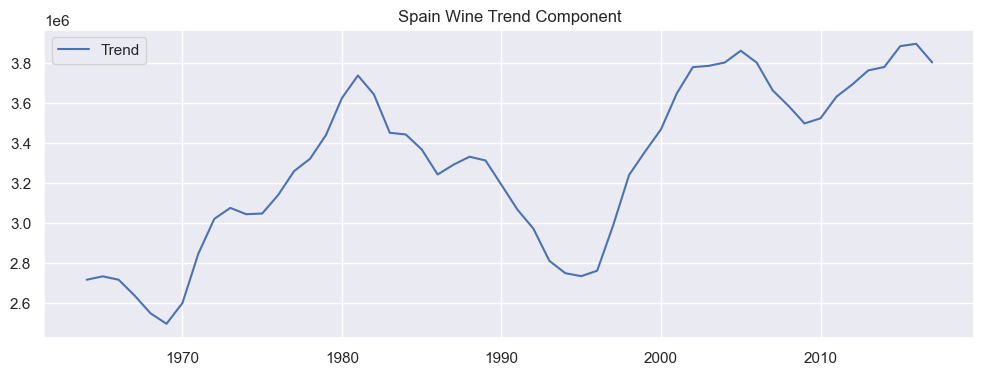

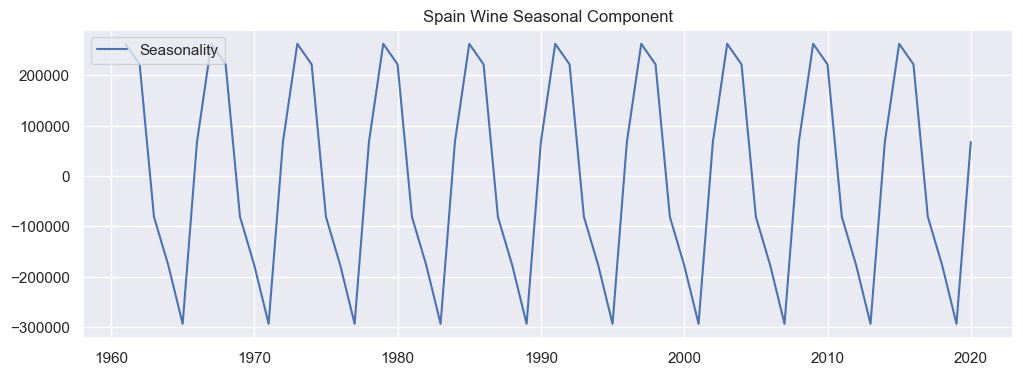

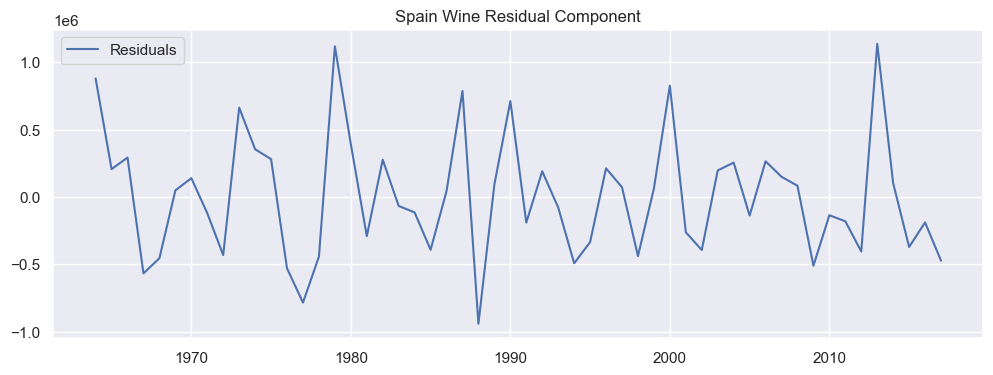

In [24]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("Spain Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("Spain Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("Spain Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

#### United States

In [25]:
# You can use 'additive' or 'multiplicative' models depending on the nature of your data
model = 'additive'  # or 'multiplicative'
#model = 'multiplicative'

# Frequency represents the number of data points per cycle (e.g., 12 for monthly data with yearly seasonality)
frequency = 4
decomposition = seasonal_decompose(wine[wine["Area"]=='United States of America'].Value, model=model, period=frequency)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

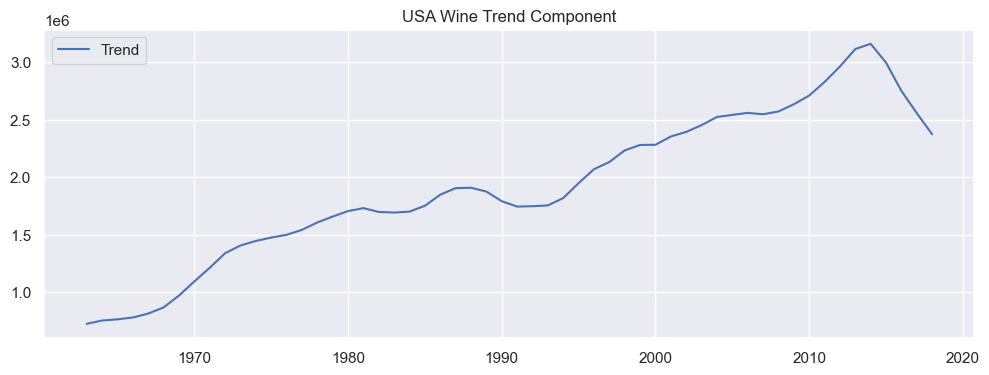

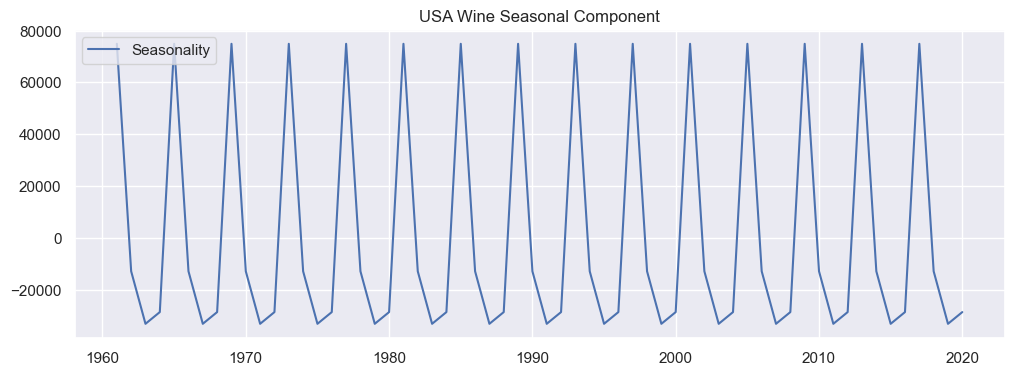

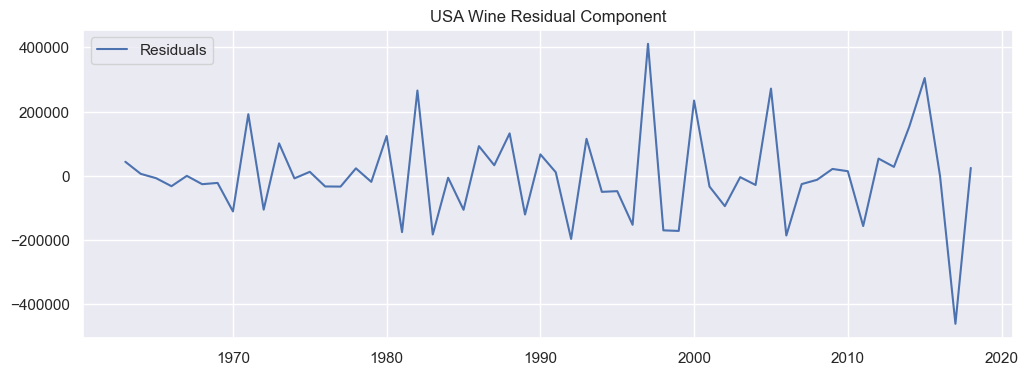

In [26]:
# 5.1 Trend Component
plt.figure(figsize=(12, 4))
plt.plot(trend, label='Trend')
plt.title("USA Wine Trend Component")
plt.legend(loc='upper left')
plt.show()

# 5.2 Seasonal Component
plt.figure(figsize=(12, 4))
plt.plot(seasonal, label='Seasonality')
plt.title("USA Wine Seasonal Component")
plt.legend(loc='upper left')
plt.show()

# 5.3 Residual Component
plt.figure(figsize=(12, 4))
plt.plot(residual, label='Residuals')
plt.title("USA Wine Residual Component")
plt.legend(loc='upper left')
plt.show()

### ACF Plots

Sinusoidal and decrease at the end so AR is present

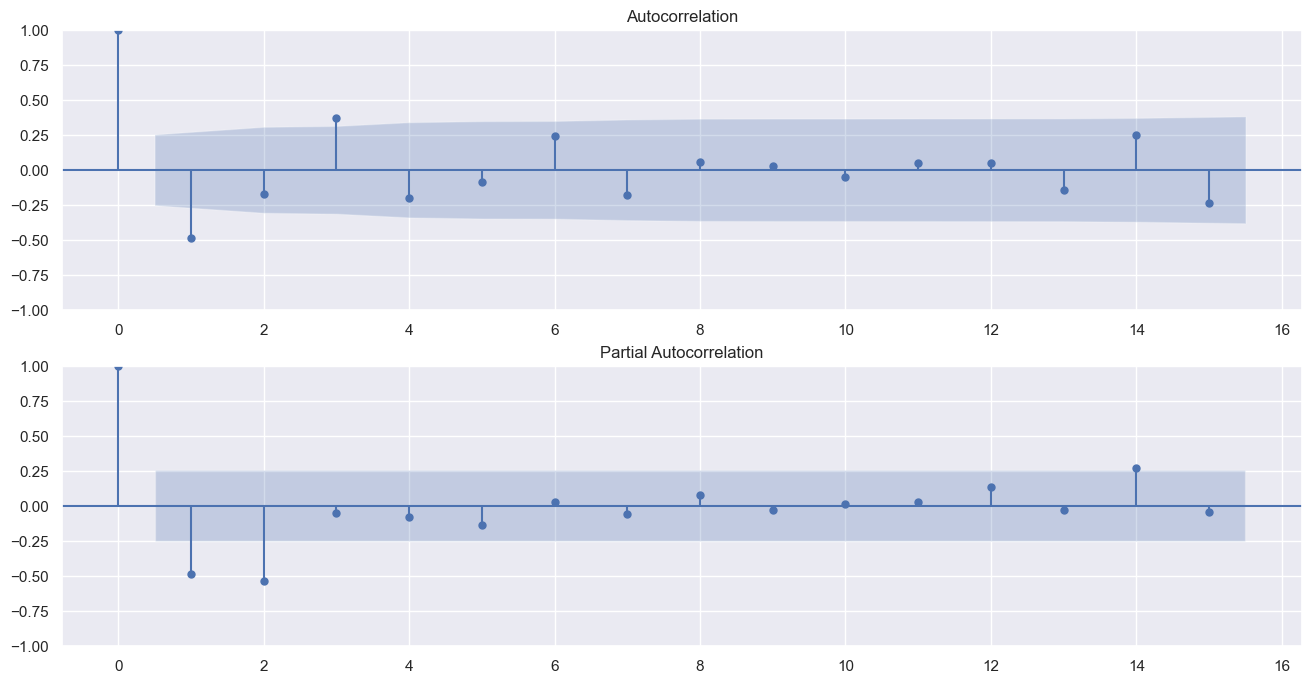

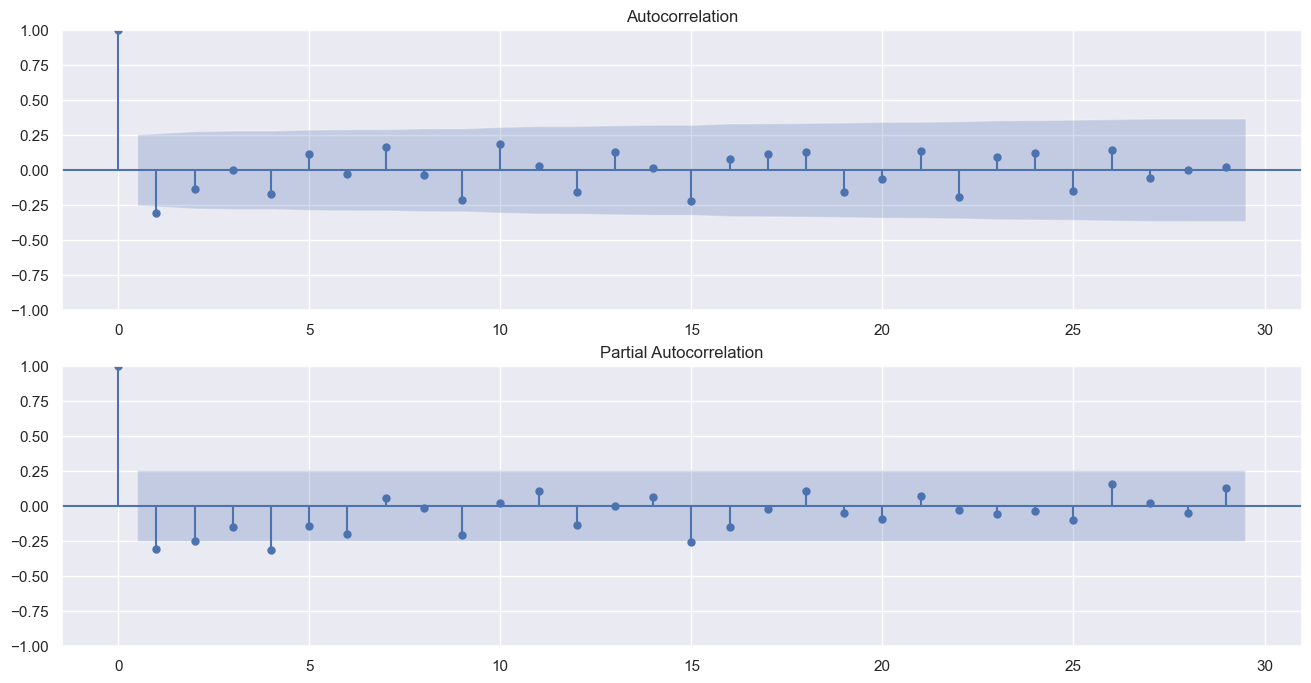

In [27]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(wine[wine['Area'] == 'France']['Value Transform'], lags=15, ax=ax[0])
plot_pacf(wine[wine['Area'] == 'France']['Value Transform'], lags=15, ax=ax[1], method='ywm')
plt.show()

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))
plot_acf(wine[wine['Area'] == 'Spain']['Value Transform'], lags=29, ax=ax[0])
plot_pacf(wine[wine['Area'] == 'Spain']['Value Transform'], lags=29, ax=ax[1], method='ywm')
plt.show()

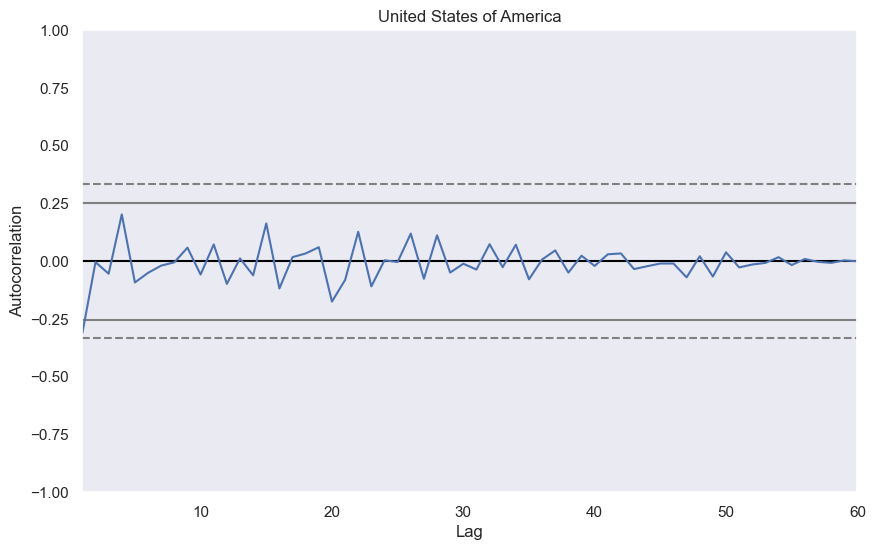

In [28]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(10,6))
autocorrelation_plot(wine[wine['Area'] == 'United States of America']['Value Transform'])
plt.title('United States of America')
plt.show()

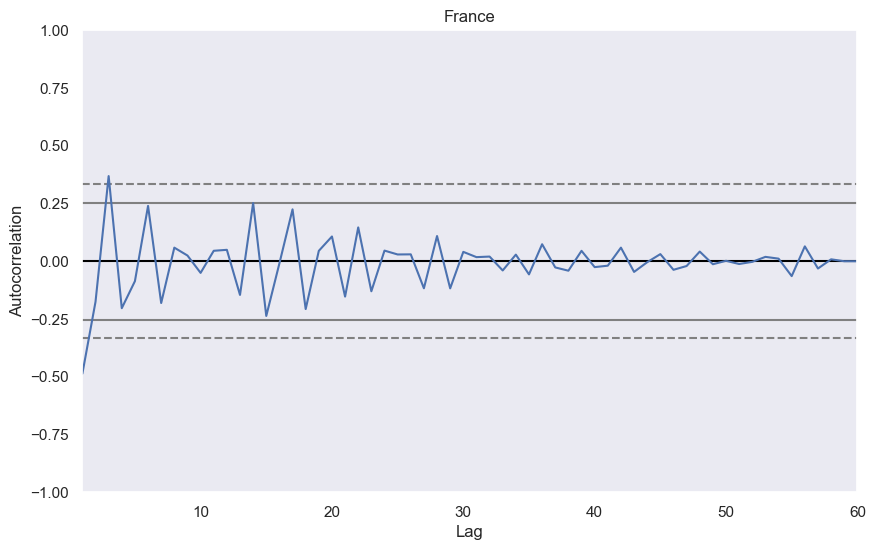

In [29]:
plt.figure(figsize=(10,6))
autocorrelation_plot(wine[wine['Area'] == 'France']['Value Transform'])
plt.title('France')
plt.show()

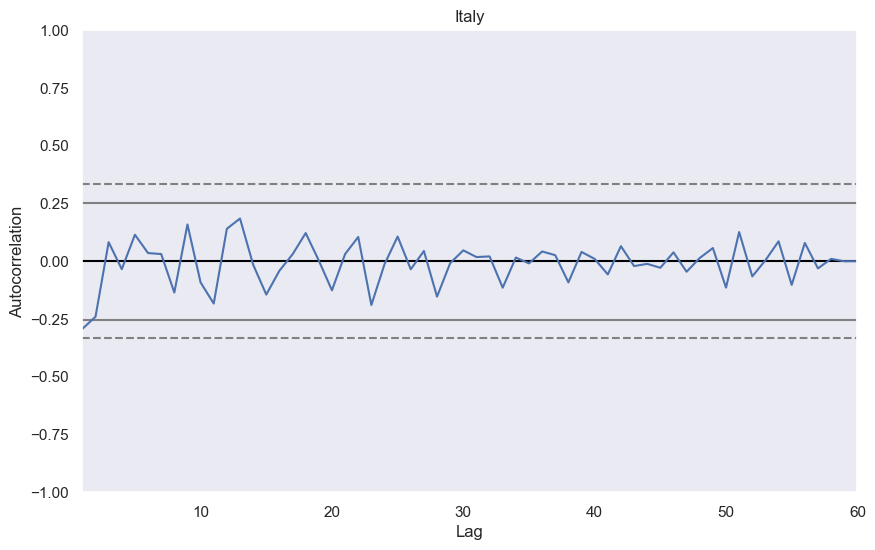

In [30]:
plt.figure(figsize=(10,6))
autocorrelation_plot(wine[wine['Area'] == 'Italy']['Value Transform'])
plt.title('Italy')
plt.show()

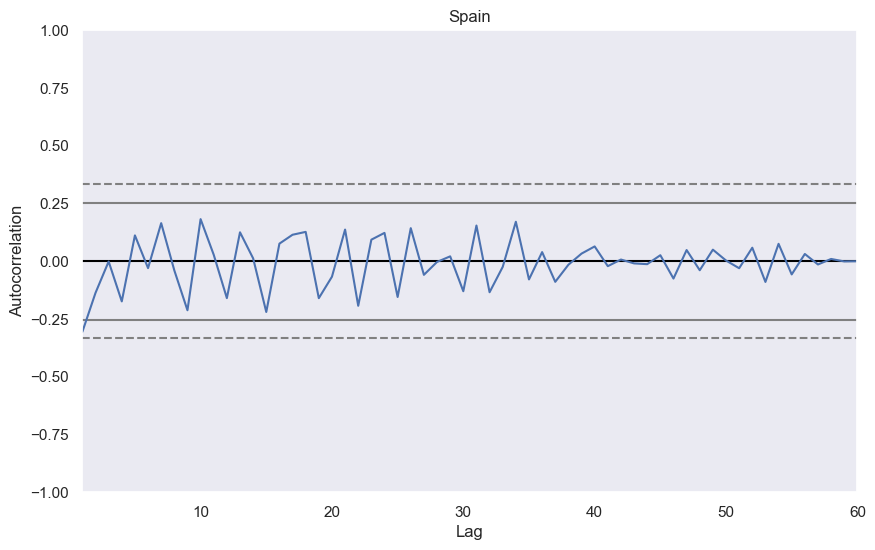

In [31]:
plt.figure(figsize=(10,6))
autocorrelation_plot(wine[wine['Area'] == 'Spain']['Value Transform'])
plt.title('Spain')
plt.show()

# ARIMA

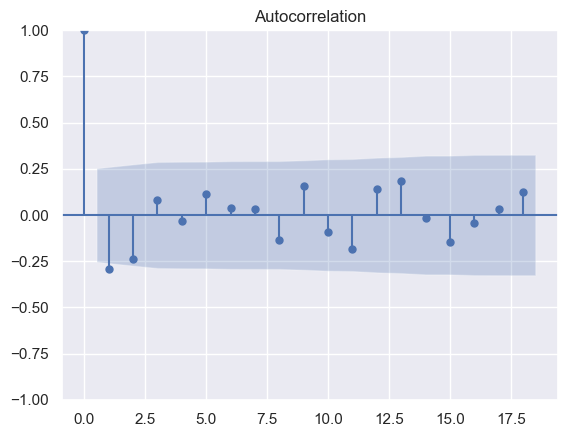

In [32]:
df_wine = wine[wine['Area'] == 'Italy'].copy()
df_wine.reset_index(inplace=True)
df_wine['Year Code'] = df_wine['Year Code'].astype('str').str[:4].astype('int')
df_wine = df_wine[['Year Code', 'Value Transform']]

# Set the column 'Date' as index (skip if already done)
df_wine = df_wine.set_index('Year Code')

train_data, test_data = df_wine[0:int(len(df_wine)*0.85)], df_wine[int(len(df_wine)*0.85):]

acf = plot_acf(df_wine['Value Transform'].dropna()) #q
plt.show()

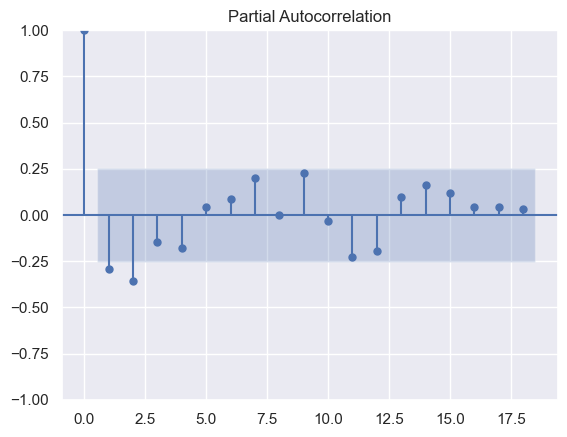

In [33]:
pacf = plot_pacf(df_wine['Value Transform'].dropna(), method='ywm') #p
plt.show()